<a href="https://colab.research.google.com/github/yanzcc/FinalPlane/blob/master/M1_Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**M1 Titanic**
This dataset comes from the most famous shipwreck of all time. The data is available from multiple locations on the web, e.g., Kaggle: https://www.kaggle.com/c/titanic/data



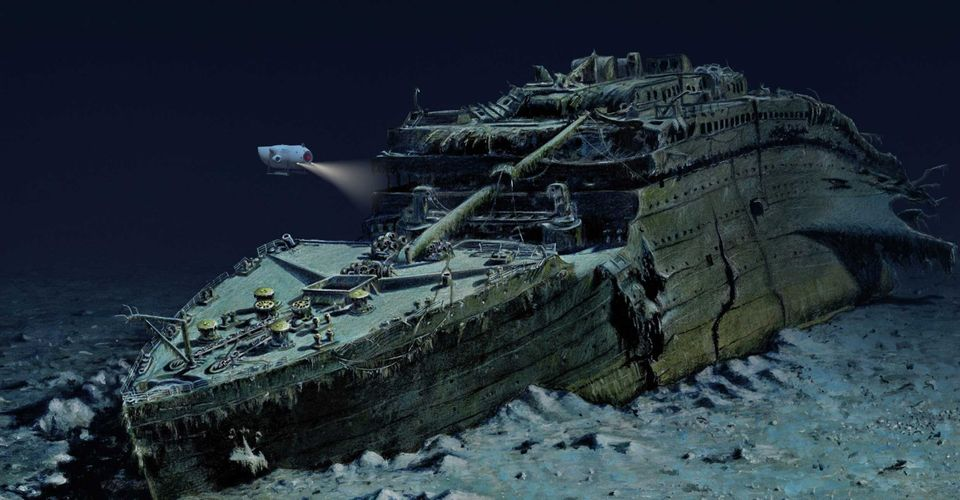

Source: https://mollybrown.org/dust-to-dust-the-titanic-today-and-in-the-future/
Fair use claimed.

#**Table of Contents**
* Business Problem
* BLUF
* Libraries
* Data
* Engineering
* Classifiers (with and without scaling and balance)
  * Decision Tree
  * PyTorch Lightning
  * LightGBM
  * PyCaret
* Conclusion

#**Business Problem**
We want to develop a classifier that can classify the survival target variable.

#**BLUF (Bottom Line Up Front)**

Four classifier tools (a decision tree model, PyTorch Lightning model, LightGBM model and PyCaret models) are built and compared with and without scaling and balancing on a holdout sample using the accuracy metric and a study of the confusion matrix

Overall, there is not much seperation in the performance. Any of the classifiers, with/without scaling, with/without balancing, and with/without CV seems to be fine (the classifiers are likely in the Rashomon set). The best practice would be to do scale, balance and cross-validate.

#**Libraries**

In [ ]:
!pip install pytorch-lightning


In [ ]:
!pip install pycaret

In [ ]:
from pycaret.datasets import get_data
from pycaret.classification import *
from pytorch_lightning import LightningModule

In [ ]:
# Basic Libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std
import scipy.stats as ss

In [ ]:
# PyTorch Lightning
import torch
from torch.utils.data import DataLoader, Dataset
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from torch import nn
from torch.nn import functional as F

In [ ]:
# Scikit learn
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import GridSearchCV

In [ ]:
# LightGBM Library
!pip install lightgbm
from lightgbm import LGBMClassifier
import lightgbm as lgb

In [ ]:
# Imblearn library
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline

#**Data**

The code below shows how to mount your Google Drive on your runtime using an authorization code, and how to write and read files there. This supports reading, writing, and moving files.

Alternatively, you could read in the data from a URL.

**Data dictionary:**

The dataset contains 1310 instances and 14 features. The features are as follows:

* pclass: class of ticket (class 1,2,3).
* survived: 0 = victim, 1 = survivor (this is the target variable)
* name: name of passenger
* sex: gender of passenger
* age: age (in years) of passenger
* sibsp: number of siblings and spouses accompanying passenger (i.e., same generation as passenger)
* parch: number of parents and children accompanying passenger (i.e., other generations than passenger)
* ticket: ticket number
* fare: fare paid by passenger
* cabin: cabin number of passenger
* embarked: port of embarkation of passenger (C = Cherbourg, Q = Queenstown, S = Southampton)
* boat: lifeboat number (if passenger survived)
* body: body number (if passenger did not survive and the body was recovered)
* home.dest: home city/destination city

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Read
file_ = "https://drive.google.com/uc?export=download&id=1pSAWy86-a_wQXbx0E-7m-zYOGYfY2Hd7"   # adapt this as needed to the file structure on your Google drive
df = pd.read_csv(file_) # read in csv file

Mounted at /content/drive


#**Engineering**

In [ ]:
# Ensure maximum display for pandas
pd.set_option('display.max_columns', None)

# Examine the data using df.head() or df.tail()
print("HEAD of df\n", df.head())
print("\nTAIL of df\n", df.tail())

# Shape of DataFrame
print("\nSHAPE of df\n", df.shape)



HEAD of df
    pclass  survived                                             name     sex  \
0     1.0       1.0                    Allen, Miss. Elisabeth Walton  female   
1     1.0       1.0                   Allison, Master. Hudson Trevor    male   
2     1.0       0.0                     Allison, Miss. Helen Loraine  female   
3     1.0       0.0             Allison, Mr. Hudson Joshua Creighton    male   
4     1.0       0.0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000    0.0    0.0   24160  211.3375       B5        S    2    NaN   
1   0.9167    1.0    2.0  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000    1.0    2.0  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0            

##**Missing Values**

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   float64
 1   survived   1309 non-null   float64
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   float64
 6   parch      1309 non-null   float64
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(7), object(7)
memory usage: 143.4+ KB
None


Missing Values
 pclass          1
survived        1
name            1
sex             1
age           264
sibsp           1
parch           1
ticket          1
fare            2
cabin        1

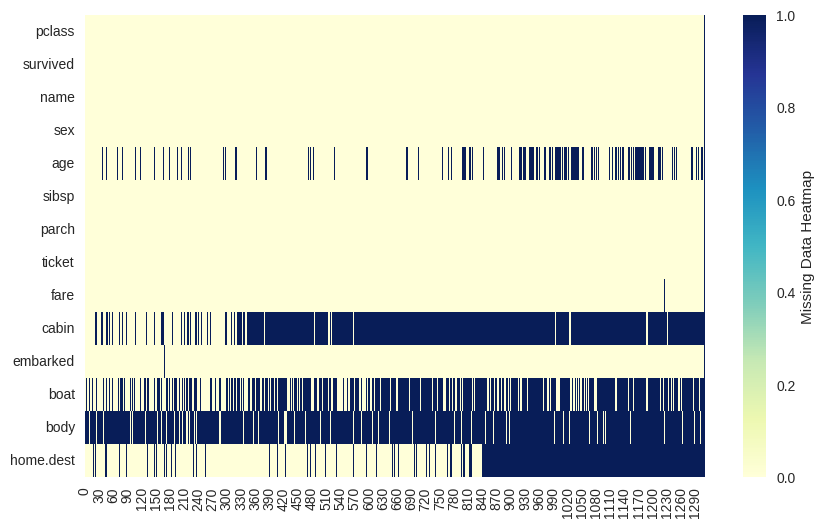

In [ ]:
# Checks
# Check data types
print(df.info())

# Check for missing values
print('\n\nMissing Values\n',df.isnull().sum(axis=0))

# Missing value heatmap
plt.figure(figsize=(10,6))
sns.heatmap(df.isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data Heatmap'})
plt.show()

In [ ]:
# Impute df[['embarked','age','fare','pclass','sex','sibsp']] using mode
cols = ['embarked','age','fare','pclass','sex','sibsp']
for i in cols:
  df[i] = df[i].fillna(df[i].mode()[0])

In [ ]:
# delete row with missing value for survived
df = df.dropna(subset=['survived'])

In [ ]:
# delete ['home_dest','body','name'] columns
df = df.drop(columns=['home.dest','body','name'])

In [ ]:
# replace missing values in columns 'boat' and 'cabin' with 0
df[['boat','cabin']] = df[['boat','cabin']].fillna(0)

In [ ]:
# Check number of missing values
df.isnull().sum()

pclass      0
survived    0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
cabin       0
embarked    0
boat        0
dtype: int64

##**Unique Values**

In [ ]:
# Calculate number of unique valus for each column in df
for i in df.columns:
  print(i, ":", df[i].nunique())


pclass : 3
survived : 2
sex : 2
age : 98
sibsp : 7
parch : 8
ticket : 929
fare : 281
cabin : 187
embarked : 3
boat : 28


##**Dummies or Labels?**

In [ ]:
# Dummy Encoding
df=pd.get_dummies(data=df,columns=['sex','embarked','pclass'],drop_first=True)

In [ ]:
# Label encode cabin, ticket and boat columns
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['cabin'] = df['cabin'].astype(str)
df['cabin'] = le.fit_transform(df['cabin'])
df['boat'] = df['boat'].astype(str)
df['boat'] = le.fit_transform(df['boat'])
df['ticket'] = df['ticket'].astype(str)
df['ticket'] = le.fit_transform(df['ticket'])

In [ ]:
df

,survived,age,sibsp,parch,ticket,fare,cabin,boat,sex_male,embarked_Q,embarked_S,pclass_2.0,pclass_3.0
0,1.0,29.0000,0.0,0.0,187,211.3375,44,12,0,0,1,0,0
1,1.0,0.9167,1.0,2.0,49,151.5500,80,3,1,0,1,0,0
2,0.0,2.0000,1.0,2.0,49,151.5500,80,0,0,0,1,0,0
3,0.0,30.0000,1.0,2.0,49,151.5500,80,0,1,0,1,0,0
4,0.0,25.0000,1.0,2.0,49,151.5500,80,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,0.0,14.5000,1.0,0.0,259,14.4542,0,0,0,0,0,0,1
1305,0.0,24.0000,1.0,0.0,259,14.4542,0,0,0,0,0,0,1
1306,0.0,26.5000,0.0,0.0,250,7.2250,0,0,1,0,0,0,1
1307,0.0,27.0000,0.0,0.0,264,7.2250,0,0,1,0,0,0,1


##**Check Balance**

In [ ]:
# count target to check dataset balance
df['survived'].value_counts()

0.0    809
1.0    500
Name: survived, dtype: int64

##**Check Skewness**

In [ ]:
# Check skewness
df.skew()

survived      0.486404
age           0.687521
sibsp         3.844220
parch         3.669078
ticket       -0.008800
fare          4.369214
cabin         2.108461
boat          1.427176
sex_male     -0.602189
embarked_Q    2.786355
embarked_S   -0.872682
pclass_2.0    1.413726
pclass_3.0   -0.167312
dtype: float64

##**Check and Resolve Dups**

In [ ]:
# Check for duplicates, finally
print('\n Duplicates\n',df.duplicated().sum())


 Duplicates
 24


In [ ]:
# Choosing to NOT remove duplicates since each row was a passenger on the Titanic. Dups may be family members.

##**Descriptive Statistics**
Descriptive statistics entails the production and interpretation of both visualizations and numerical statistics.
* Numerical univariate statistics: mean, median, mode, trimmed mean, standard deviation, skewness, kurtosis, quartiles, IQR, range, etc.
* Numerical bivariate statistics: correlation, covariance, crosstabs, etc.
* Univariate graphs: box plots, violin plots, bar charts, histograms (i.e., prefer to avoid pie charts!)
* Bivariate & multivariate graphs: scatter plots, line charts, stacked/grouped histograms, stacked/grouped bar charts, side-by-side box plots, parallel coordinate plots, scatterplot matrices (“pairplots”), etc.

In [ ]:
# Univariate descriptive statistics using pandas

# Ensure the maximum number of columns are displayed in pandas
pd.set_option('display.max_columns', None)

# Univariate numerical statistics using pandas .describe
print("UNIVARIATE DESCRIPTIVE STAT using pandas\n",df.describe(include='all').T)
print("\n SKEWNESS\n",df.skew())
print("\n FISHER'S KURTOSIS\n",df.kurt())

UNIVARIATE DESCRIPTIVE STAT using pandas
              count        mean         std     min       25%       50%  \
survived    1309.0    0.381971    0.486055  0.0000    0.0000    0.0000   
age         1309.0   28.699516   13.097103  0.1667   22.0000   24.0000   
sibsp       1309.0    0.498854    1.041658  0.0000    0.0000    0.0000   
parch       1309.0    0.385027    0.865560  0.0000    0.0000    0.0000   
ticket      1309.0  463.625668  278.069490  0.0000  212.0000  459.0000   
fare        1309.0   33.276193   51.743584  0.0000    7.8958   14.4542   
cabin       1309.0   22.040489   47.821397  0.0000    0.0000    0.0000   
boat        1309.0    4.972498    8.004157  0.0000    0.0000    0.0000   
sex_male    1309.0    0.644003    0.478997  0.0000    0.0000    1.0000   
embarked_Q  1309.0    0.093965    0.291891  0.0000    0.0000    0.0000   
embarked_S  1309.0    0.699771    0.458533  0.0000    0.0000    1.0000   
pclass_2.0  1309.0    0.211612    0.408607  0.0000    0.0000    0.0000

CORRELATION MATRIX
             survived       age     sibsp     parch    ticket      fare  \
survived    1.000000 -0.029985 -0.027825  0.082660 -0.125869  0.244479   
age        -0.029985  1.000000 -0.186248 -0.113955 -0.092268  0.191306   
sibsp      -0.027825 -0.186248  1.000000  0.373587  0.063921  0.160388   
parch       0.082660 -0.113955  0.373587  1.000000  0.053389  0.221668   
ticket     -0.125869 -0.092268  0.063921  0.053389  1.000000 -0.014959   
fare        0.244479  0.191306  0.160388  0.221668 -0.014959  1.000000   
cabin       0.263782  0.201867 -0.005685  0.029582 -0.184385  0.340331   
boat        0.755150  0.015592 -0.036957  0.043684 -0.157350  0.224800   
sex_male   -0.528693  0.045260 -0.109609 -0.213125  0.024725 -0.185744   
embarked_Q -0.016071 -0.069303 -0.048678 -0.100943  0.060143 -0.129922   
embarked_S -0.150542 -0.019224  0.073709  0.071881  0.008784 -0.170123   
pclass_2.0  0.050790  0.019355 -0.052419 -0.010057 -0.087610 -0.121168   
pclass_3.0 -0.2834

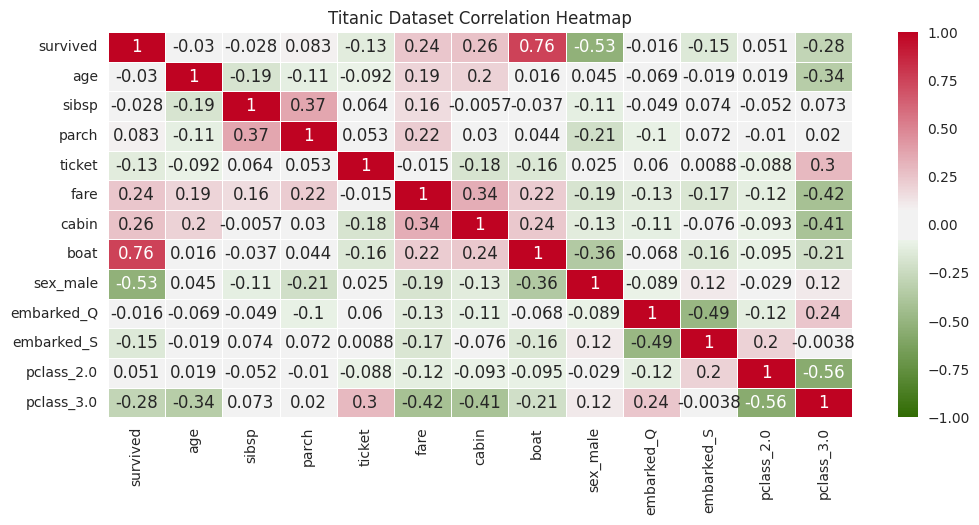

In [ ]:
# Multivariate numerical descriptive statistics

#Correlation Matrix
print("CORRELATION MATRIX\n",df.corr(method='pearson', min_periods=1))
print("\n\n")

#Correlation Matrix as a Heatmap
sns.set_style('darkgrid')
plt.figure(figsize = (12,5))
cmap = sns.diverging_palette(120, 10, l = 40, s = 99, sep = 20, center = 'light', as_cmap = True)
sns.heatmap((df).corr(), vmin = -1, vmax = 1, annot = True, cmap = cmap, lw = .5, linecolor = 'white')
plt.title("Titanic Dataset Correlation Heatmap")
plt.show()


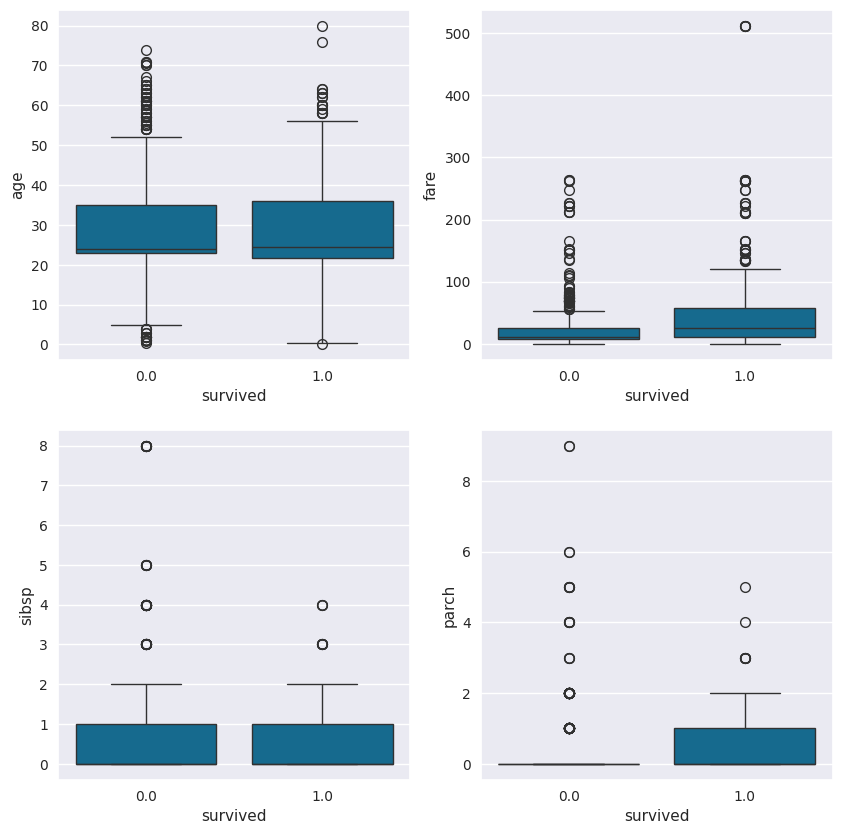

In [ ]:
# Bivariate Graphical Descriptive Statistics
# Side-by-side Boxplots

fig, axes = plt.subplots(2, 2, figsize=(10,10))
sns.boxplot(  y="age", x= "survived", data=df,  orient='v' , ax=axes[0, 0])
sns.boxplot(  y="fare", x= "survived", data=df,  orient='v' , ax=axes[0, 1])
sns.boxplot(  y="sibsp", x= "survived", data=df,  orient='v' , ax=axes[1, 0])
sns.boxplot(  y="parch", x= "survived", data=df,  orient='v' , ax=axes[1, 1])
plt.show()

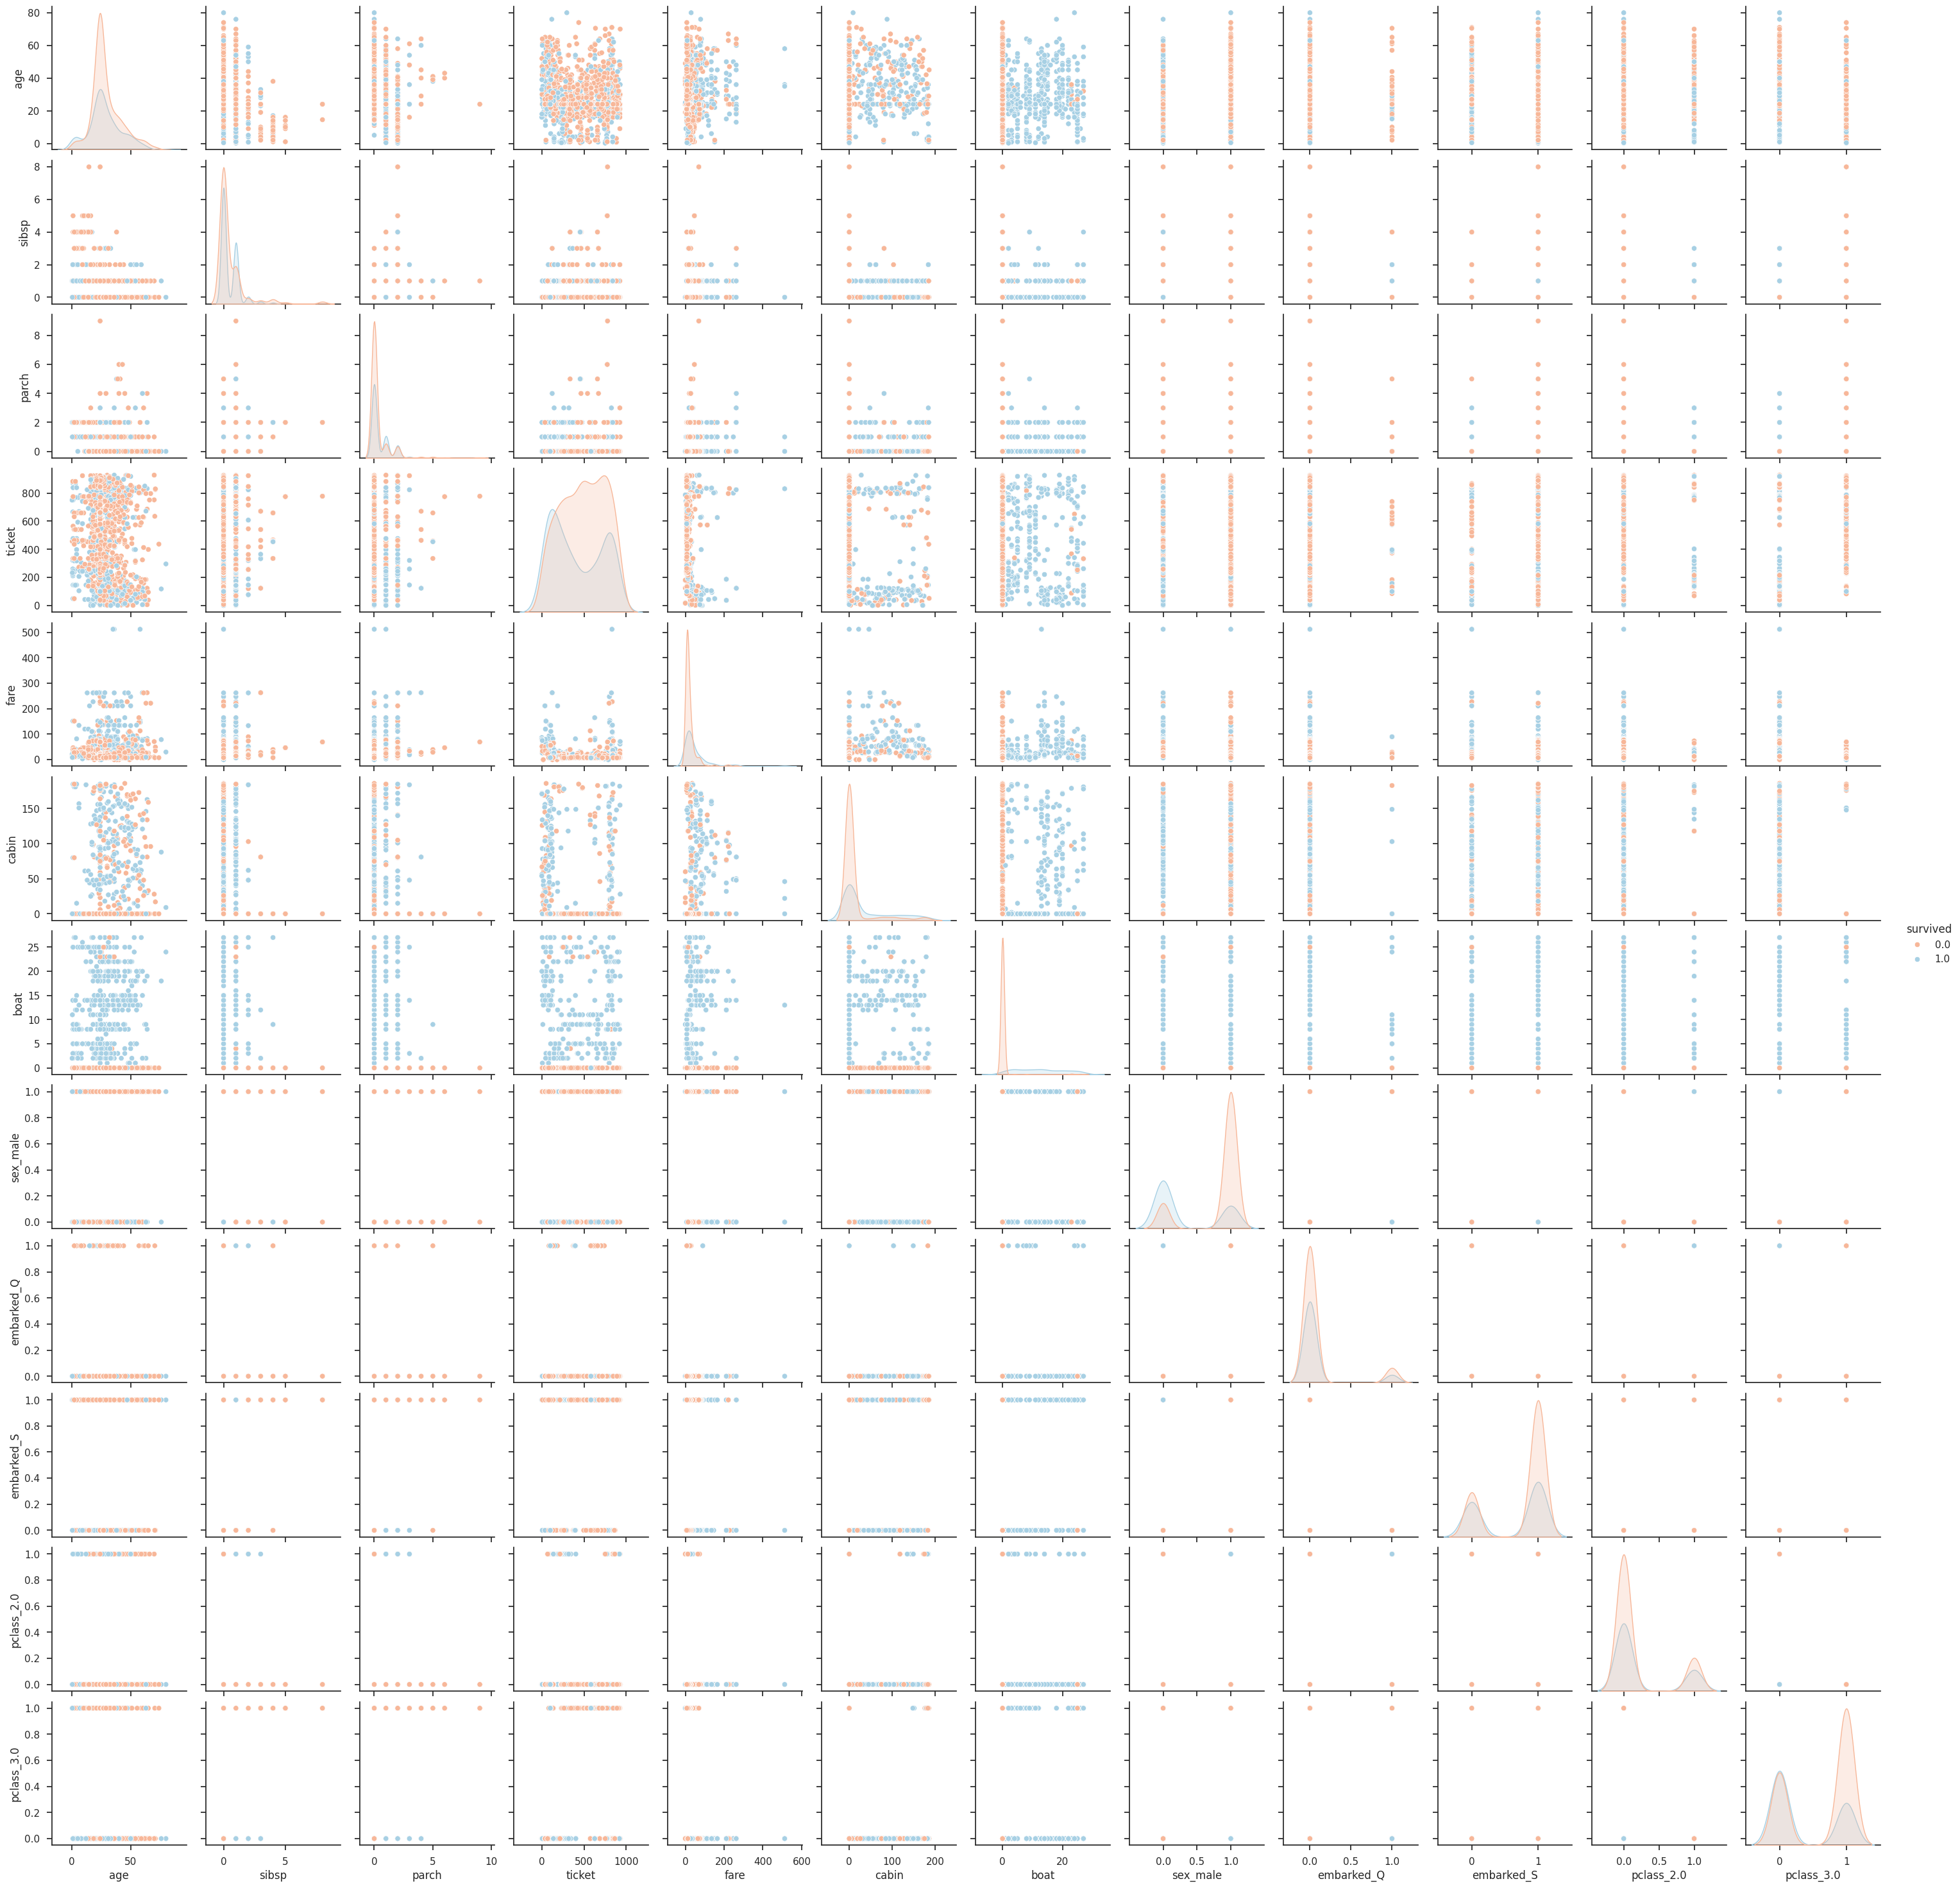

In [ ]:
# Scatterplot matrix (aka pairplot) - these can take some time to generate if the number of features is large
# Red: died, blue: survived.

sns.set_theme(style="ticks")
sns.color_palette("hls", 8)
sns.pairplot(df, hue="survived",palette="RdBu")

#**Classifiers**

##**Experimental Setup**

In [ ]:
# Set up predictors (X) and target (y)
X = df.drop('survived', axis=1)
y = df['survived']
feature_names = X.columns

# Split the data into training and testing sets. This is  HOLDOUT SAMPLE.
HS_X_train, HS_X_test, HS_y_train, HS_y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # COMMENT OUT THIS CODEBLOCK TO TURN OFF STANDARDIZATION OF THE HOLDOUT SAMPLE!!
# Standardize features
scaler = StandardScaler()
HS_X_train = scaler.fit_transform(HS_X_train)
HS_X_test = scaler.transform(HS_X_test)

# COMMENT OUT THIS CODEBLOCK TO TURN OFF SMOTE OF THE HOLDOUT SAMPLE!!
# Apply SMOTE to balance the training dataset
smote = SMOTE(random_state=42)
HS_X_train, HS_y_train = smote.fit_resample(HS_X_train, HS_y_train)



##**Decision Tree Classifier**

In [ ]:
# # COMMENT OUT "('scaler', StandardScaler())," TO TURN OFF STANDARDIZATION!!
# # COMMENT OUT "('smote', SMOTE(random_state=42))," TO TURN OFF SMOTE!!
# Create a pipeline that includes scaling, balancing with SMOTE, and a decision tree classifier
pipeline = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# # SET cv=None to TURN OFF CROSS-VALIDATION!!
# Perform cross-validation on the full dataset
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores.mean()}")

# Fit the pipeline on the HOLD OUT training set and predict on the HOLDOUT test set
pipeline.fit(HS_X_train, HS_y_train)
y_pred = pipeline.predict(HS_X_test)

# Evaluate the predictions
accuracy = accuracy_score(HS_y_test, y_pred)
conf_matrix = confusion_matrix(HS_y_test, y_pred)

print(f"Holdout Sample Test Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)


Cross-validation scores: 0.9419437863765318
Holdout Sample Test Accuracy: 0.9694656488549618
Confusion Matrix:
[[142   2]
 [  6 112]]


##**PyTorch Lightning Classifier**

This creates a neural network solution.

In [ ]:
if isinstance(HS_X_train, pd.DataFrame):
        HS_X_train = HS_X_train.values
if isinstance(HS_y_train, pd.DataFrame):
        HS_y_train = HS_y_train.values
if isinstance(HS_X_test, pd.DataFrame):
        HS_X_test = HS_X_test.values
if isinstance(HS_y_test, pd.DataFrame):
        HS_y_test = HS_y_test.values

class TitanicDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TitanicDataset(HS_X_train, HS_y_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

class TitanicModel(LightningModule):
    def __init__(self):
        super(TitanicModel, self).__init__()
        self.fc1 = nn.Linear(12, 20)  # Assuming 5 input features
        self.fc2 = nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.binary_cross_entropy(y_hat, y.view(-1, 1))
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

# Create the PyTorch Lightning model
model = TitanicModel()

# Train the model
trainer = Trainer(max_epochs=100)
trainer.fit(model, train_loader)

class TestDataset(Dataset):
    def __init__(self, X):
        self.X = torch.tensor(X, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx]

test_dataset = TestDataset(HS_X_test)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Function to predict test data
def predict(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    with torch.no_grad():
        for batch in dataloader:
            batch = batch[0] if isinstance(batch, list) else batch
            preds = model(batch).squeeze()
            preds = torch.round(preds)  # Convert probabilities to class labels (0 or 1)
            predictions.extend(preds.cpu().numpy())
    return np.array(predictions)

# Predict the test data
y_pred = predict(model, test_loader)

# Calculate the confusion matrix and accuracy
conf_matrix = confusion_matrix(HS_y_test, y_pred)
accuracy = accuracy_score(HS_y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)
print("\nHoldout Sample Test Accuracy:", accuracy)


INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type   | Params
--------------------------------
0 | fc1  | Linear | 260   
1 | fc2  | Linear | 21    
--------------------------------
281       Trainable params
0         Non-trainable params
281       Total params
0.001     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


Confusion Matrix:
[[141   3]
 [  8 110]]

Holdout Sample Test Accuracy: 0.9580152671755725


##**LightGBM Classifier**

In [ ]:
# # COMMENT OUT "('scaler', StandardScaler())," TO TURN OFF STANDARDIZATION!!
# # COMMENT OUT "('smote', SMOTE(random_state=42))," TO TURN OFF SMOTE!!
# Create a pipeline that includes scaling, balancing with SMOTE, and a decision tree classifier
pipeline = imbpipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', lgb.LGBMClassifier(random_state=42,verbose=-1))
])

# # SET cv=None to TURN OFF CROSS-VALIDATION!!
# Perform cross-validation on the full dataset
scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores.mean()}")

# Fit the pipeline on the HOLD OUT training set and predict on the HOLDOUT test set
pipeline.fit(HS_X_train, HS_y_train)
y_pred = pipeline.predict(HS_X_test)

# Evaluate the predictions
accuracy = accuracy_score(HS_y_test, y_pred)
conf_matrix = confusion_matrix(HS_y_test, y_pred)

print(f"Holdout Sample Test Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)

Cross-validation scores: 0.9640899651955193
Holdout Sample Test Accuracy: 0.9694656488549618
Confusion Matrix:
[[142   2]
 [  6 112]]


##**PyCaret Low-Code Classifier**

In [ ]:
# ADJUST normalize, fix_imbalance AND fold TO TURN STANDARDIZATION, BALANCE AND CROSS-VALIDATION ON/OFF
# THE MINIMUM VALUE OF fold is 2 (THERE IS NO WAY TO USE THIS CODE TO EVALUATE PYCARET ON THE HOLDOUT SAMPLE ONLY)
clf_setup = setup(data=df,
                  train_size = 0.8,
                  target='survived',
                  normalize=True,
                  fix_imbalance=True,
                  session_id=42, fold=5)


# Compare models to choose the best one
best_model = compare_models()

# Create a model; here, we use the best model found by compare_models
# For example, if Logistic Regression was the best: model = create_model('lr')
model = create_model(best_model)

# Tune the model for better performance (optional)
tuned_model = tune_model(model)

# Finalize the model (trains on the whole dataset)
final_model = finalize_model(tuned_model)

# Predict on the test set
predict_model(final_model);

# Display the accuracy and confusion matrix
evaluate_model(final_model)


,Description,Value
0,Session id,42
1,Target,survived
2,Target type,Binary
3,Original data shape,"(1309, 13)"
4,Transformed data shape,"(1556, 13)"
5,Transformed train set shape,"(1294, 13)"
6,Transformed test set shape,"(262, 13)"
7,Numeric features,12
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.9780,0.9312,0.9650,0.9773,0.9710,0.9533,0.9535,0.4660
rf,Random Forest Classifier,0.9761,0.9147,0.9625,0.9749,0.9685,0.9493,0.9495,0.2940
ada,Ada Boost Classifier,0.9752,0.8834,0.9575,0.9774,0.9671,0.9471,0.9476,0.1920
lightgbm,Light Gradient Boosting Machine,0.9732,0.9014,0.9600,0.9697,0.9648,0.9432,0.9433,0.4020
xgboost,Extreme Gradient Boosting,0.9723,0.9203,0.9575,0.9696,0.9635,0.9411,0.9412,0.1260
et,Extra Trees Classifier,0.9666,0.8917,0.9525,0.9599,0.9560,0.9291,0.9293,0.2460
dt,Decision Tree Classifier,0.9580,0.8691,0.9425,0.9474,0.9447,0.9108,0.9111,0.0680
lr,Logistic Regression,0.9532,0.8520,0.9175,0.9592,0.9373,0.9000,0.9012,1.2720
svm,SVM - Linear Kernel,0.9350,0.0000,0.8775,0.9495,0.9118,0.8605,0.8624,0.0560
qda,Quadratic Discriminant Analysis,0.9198,0.7916,0.9000,0.8935,0.8956,0.8305,0.8320,0.0860


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9905,0.9617,0.9875,0.9875,0.9875,0.9798,0.9798
1,0.9714,0.9079,0.9500,0.9744,0.9620,0.9391,0.9393
2,0.9809,0.9315,0.9750,0.9750,0.9750,0.9595,0.9595
3,0.9713,0.9390,0.9625,0.9625,0.9625,0.9392,0.9392
4,0.9761,0.9157,0.9500,0.9870,0.9682,0.9490,0.9495
Mean,0.9780,0.9312,0.9650,0.9773,0.9710,0.9533,0.9535
Std,0.0072,0.0188,0.0146,0.0093,0.0095,0.0152,0.0152


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9905,0.9601,0.9875,0.9875,0.9875,0.9798,0.9798
1,0.9714,0.9231,0.9500,0.9744,0.9620,0.9391,0.9393
2,0.9761,0.9111,0.9625,0.9747,0.9686,0.9492,0.9493
3,0.9761,0.7551,0.9500,0.9870,0.9682,0.9490,0.9495
4,0.9761,0.9137,0.9375,1.0000,0.9677,0.9488,0.9500
Mean,0.9780,0.8926,0.9575,0.9847,0.9708,0.9532,0.9536
Std,0.0065,0.0710,0.0170,0.0095,0.0087,0.0138,0.0137


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 5 folds for each of 10 candidates, totalling 50 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.9733,0.9982,0.9600,0.9697,0.9648,0.9433,0.9433


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

#**Conclusions**

The performance of the classifier tools is shown in the table below for the following cases:
- Base case: no scaling, no balancing, no cross-validation
- Sacled: Scaling only
- Balanced: Balancing only
- CV: Cross-validation only
- Comprehensive case: scaling, balancing and cross-validation

|**Regressor** |       Accuracy      | Confusion Matrix |
|:----------------------|:--------------:|:--------------:|
|Decision Tree Base | 0.966 | $$\begin{bmatrix} 142 & 2 \\ 7 & 111\\\end{bmatrix}$$ |
|Decision Tree Scaled   | 0.966 | $$\begin{bmatrix} 142 & 2 \\ 7 & 111\\\end{bmatrix}$$ |
|Decision Tree Balanced | 0.969 | $$\begin{bmatrix} 142 & 2 \\ 6 & 112\\\end{bmatrix}$$ |
|Decision Tree CV | 0.966 | $$\begin{bmatrix} 142 & 2 \\ 7 & 111\\\end{bmatrix}$$ |
|Decision Tree Comprehensive | 0.970 | $$\begin{bmatrix} 142 & 2 \\ 6 & 112\\\end{bmatrix}$$ |
|PyTorch Lightning Base | 0.954 | $$\begin{bmatrix} 144 & 0 \\ 12 & 106\\\end{bmatrix}$$ |
|PyTorch Lightning Scaled   | 0.958 | $$\begin{bmatrix} 144 & 0 \\ 11 & 107\\\end{bmatrix}$$ |
|PyTorch Lightning Balanced | 0.958 | $$\begin{bmatrix} 144 & 0 \\ 11 & 107\\\end{bmatrix}$$ |
|PyTorch Lightning CV | NA | NA |
|PyTorch Lightning Comprehensive | 0.962 | $$\begin{bmatrix} 144 & 0 \\ 10 & 108\\\end{bmatrix}$$ |
|LightGBM Base | 0.963 | $$\begin{bmatrix} 142 & 2 \\ 6 & 112\\\end{bmatrix}$$ |
|LightGBM Scaled   | 0.966 | $$\begin{bmatrix} 142 & 2 \\ 7 & 111\\\end{bmatrix}$$ |
|LightGBM Balanced | 0.960 | $$\begin{bmatrix} 142 & 2 \\ 7 & 111\\\end{bmatrix}$$ |
|LightGBM CV | 0.970 | $$\begin{bmatrix} 142 & 2 \\ 6 & 112\\\end{bmatrix}$$ |
|LightGBM SComprehensive | 0.964 | $$\begin{bmatrix} 142 & 2 \\ 6 & 112\\\end{bmatrix}$$ |
|PyCaret Base (AdaBoost) | 0.978 | $$\begin{bmatrix} 159 & 3 \\ 6 & 94\\\end{bmatrix}$$ |
|PyCaret Scaled (Adaboost)   | 0.978 | $$\begin{bmatrix} 159 & 3 \\ 6 & 94\\\end{bmatrix}$$ |
|PyCaret Balanced (Adaboost)   | 0.978 | $$\begin{bmatrix} 159 & 3 \\ 6 & 94\\\end{bmatrix}$$ |
|PyCaret CV (Gradient Boost Classifier) | 0.978 | $$\begin{bmatrix} 161 & 1 \\ 2 & 98\\\end{bmatrix}$$ |
|PyCaret Comprehensive (Gradient Boosting Classifier) | 0.978 | $$\begin{bmatrix} 159 & 3 \\ 4 & 96\\\end{bmatrix}$$ |


Overall, there is not much seperation in the performance. Any of the classifiers, with/without scaling, with/without balancing, and with/without CV seems to be fine (the classifiers are likely in the Rashomon set). The best practice would be to do scale, balance and cross-validate.


